In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms, models, datasets
from torchvision.datasets import ImageFolder
import os
import sys
import numpy as np
import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt15
import kagglehub

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


from google.colab import drive
drive.mount('/content/drive', force_remount=False)
SAVE_DIR = '/content/drive/MyDrive/comp576final'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


path = kagglehub.dataset_download("emmarex/plantdisease")
print(f"Download path: {path}")
data_dir = os.path.join(path, 'PlantVillage')
print(f"Dataset directory: {data_dir}")

class DatasetWrapper(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

class EarlyStopper:
    def __init__(self, patience=7, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        elif val_loss > self.best_loss + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop

class ResNet18Plant(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        if pretrained:
            backbone = models.resnet18(weights="IMAGENET1K_V1")
        else:
            backbone = models.resnet18(weights=None)

        self.features = nn.Sequential(*list(backbone.children())[:-2])
        in_channels = 512
        self.classifier = nn.Sequential(
            nn.Linear(in_channels * 2, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        gap = F.adaptive_avg_pool2d(x, 1).view(x.size(0), -1)
        gmp = F.adaptive_max_pool2d(x, 1).view(x.size(0), -1)
        feat = torch.cat([gap, gmp], dim=1)
        out = self.classifier(feat)
        return out

Mounted at /content/drive
Using Colab cache for faster access to the 'plantdisease' dataset.
Download path: /kaggle/input/plantdisease
Dataset directory: /kaggle/input/plantdisease/PlantVillage


Teacher Model: best_improved_resnet18plant.pth
Number of classes: 15
Total images: 20638
Using saved split: Train=16512, Val=2063, Test=2063
Teacher (ResNet18Plant):
  - Parameters: 11,443,279 (11.44M)
Student (Custom CNN):
  - Parameters: 459,023 (0.46M)
Compression ratio: 24.93x
Model size reduction: 96.0%
Distillation hyperparameters:
  - Temperature: 4.0
  - Alpha (distillation weight): 0.7
  - Learning rate: 0.0001
  - Epochs: 40
  - Batch size: 32
Epoch 1/40


Distillation Training:   0%|          | 0/516 [00:00<?, ?it/s]

Validating:   0%|          | 0/65 [00:00<?, ?it/s]

Train Loss: 8.5871 (Distill: 11.4762, Student: 1.8459)
Train Acc: 41.70%
Val Loss: 1.2292, Val Acc: 60.54% | LR: 1.0e-04
Saved best student model with val accuracy: 60.54%
Epoch 2/40


Distillation Training:   0%|          | 0/516 [00:00<?, ?it/s]

Validating:   0%|          | 0/65 [00:00<?, ?it/s]

Train Loss: 6.0578 (Distill: 8.1028, Student: 1.2862)
Train Acc: 60.62%
Val Loss: 0.8306, Val Acc: 70.14% | LR: 1.0e-04
Saved best student model with val accuracy: 70.14%
Epoch 3/40


Distillation Training:   0%|          | 0/516 [00:00<?, ?it/s]

Validating:   0%|          | 0/65 [00:00<?, ?it/s]

Train Loss: 4.9846 (Distill: 6.6856, Student: 1.0156)
Train Acc: 68.37%
Val Loss: 0.6341, Val Acc: 78.53% | LR: 1.0e-04
Saved best student model with val accuracy: 78.53%
Epoch 4/40


Distillation Training:   0%|          | 0/516 [00:00<?, ?it/s]

Validating:   0%|          | 0/65 [00:00<?, ?it/s]

Train Loss: 4.3137 (Distill: 5.8137, Student: 0.8137)
Train Acc: 74.20%
Val Loss: 0.5318, Val Acc: 83.76% | LR: 1.0e-04
Saved best student model with val accuracy: 83.76%
Epoch 5/40


Distillation Training:   0%|          | 0/516 [00:00<?, ?it/s]

Validating:   0%|          | 0/65 [00:00<?, ?it/s]

Train Loss: 3.8391 (Distill: 5.1944, Student: 0.6769)
Train Acc: 78.51%
Val Loss: 0.4758, Val Acc: 85.65% | LR: 1.0e-04
Saved best student model with val accuracy: 85.65%
Epoch 6/40


Distillation Training:   0%|          | 0/516 [00:00<?, ?it/s]

Validating:   0%|          | 0/65 [00:00<?, ?it/s]

Train Loss: 3.5496 (Distill: 4.8130, Student: 0.6019)
Train Acc: 81.12%
Val Loss: 0.4193, Val Acc: 86.77% | LR: 1.0e-04
Saved best student model with val accuracy: 86.77%
Epoch 7/40


Distillation Training:   0%|          | 0/516 [00:00<?, ?it/s]

Validating:   0%|          | 0/65 [00:00<?, ?it/s]

Train Loss: 3.3129 (Distill: 4.5013, Student: 0.5399)
Train Acc: 83.05%
Val Loss: 0.3301, Val Acc: 89.68% | LR: 1.0e-04
Saved best student model with val accuracy: 89.68%
Epoch 8/40


Distillation Training:   0%|          | 0/516 [00:00<?, ?it/s]

Validating:   0%|          | 0/65 [00:00<?, ?it/s]

Train Loss: 3.1077 (Distill: 4.2272, Student: 0.4955)
Train Acc: 84.53%
Val Loss: 0.2785, Val Acc: 90.79% | LR: 1.0e-04
Saved best student model with val accuracy: 90.79%
Epoch 9/40


Distillation Training:   0%|          | 0/516 [00:00<?, ?it/s]

Validating:   0%|          | 0/65 [00:00<?, ?it/s]

Train Loss: 2.9418 (Distill: 4.0079, Student: 0.4542)
Train Acc: 85.99%
Val Loss: 0.2317, Val Acc: 92.29% | LR: 1.0e-04
Saved best student model with val accuracy: 92.29%
Epoch 10/40


Distillation Training:   0%|          | 0/516 [00:00<?, ?it/s]

Validating:   0%|          | 0/65 [00:00<?, ?it/s]

Train Loss: 2.7828 (Distill: 3.8022, Student: 0.4041)
Train Acc: 87.50%
Val Loss: 0.2510, Val Acc: 92.10% | LR: 1.0e-04
Epoch 11/40


Distillation Training:   0%|          | 0/516 [00:00<?, ?it/s]

Validating:   0%|          | 0/65 [00:00<?, ?it/s]

Train Loss: 2.6654 (Distill: 3.6414, Student: 0.3879)
Train Acc: 87.63%
Val Loss: 0.2422, Val Acc: 92.24% | LR: 1.0e-04
Epoch 12/40


Distillation Training:   0%|          | 0/516 [00:00<?, ?it/s]

Validating:   0%|          | 0/65 [00:00<?, ?it/s]

Train Loss: 2.5784 (Distill: 3.5278, Student: 0.3633)
Train Acc: 88.77%
Val Loss: 0.2498, Val Acc: 92.15% | LR: 1.0e-04
Epoch 13/40


Distillation Training:   0%|          | 0/516 [00:00<?, ?it/s]

Validating:   0%|          | 0/65 [00:00<?, ?it/s]

Train Loss: 2.4680 (Distill: 3.3809, Student: 0.3379)
Train Acc: 89.21%
Val Loss: 0.2254, Val Acc: 92.73% | LR: 1.0e-04
Saved best student model with val accuracy: 92.73%
Epoch 14/40


Distillation Training:   0%|          | 0/516 [00:00<?, ?it/s]

Validating:   0%|          | 0/65 [00:00<?, ?it/s]

Train Loss: 2.3920 (Distill: 3.2830, Student: 0.3128)
Train Acc: 90.15%
Val Loss: 0.2122, Val Acc: 92.29% | LR: 1.0e-04
Epoch 15/40


Distillation Training:   0%|          | 0/516 [00:00<?, ?it/s]

Validating:   0%|          | 0/65 [00:00<?, ?it/s]

Train Loss: 2.3045 (Distill: 3.1661, Student: 0.2942)
Train Acc: 90.56%
Val Loss: 0.1896, Val Acc: 94.09% | LR: 1.0e-04
Saved best student model with val accuracy: 94.09%
Epoch 16/40


Distillation Training:   0%|          | 0/516 [00:00<?, ?it/s]

Validating:   0%|          | 0/65 [00:00<?, ?it/s]

Train Loss: 2.2167 (Distill: 3.0474, Student: 0.2785)
Train Acc: 91.36%
Val Loss: 0.1569, Val Acc: 94.62% | LR: 1.0e-04
Saved best student model with val accuracy: 94.62%
Epoch 17/40


Distillation Training:   0%|          | 0/516 [00:00<?, ?it/s]

Validating:   0%|          | 0/65 [00:00<?, ?it/s]

Train Loss: 2.1494 (Distill: 2.9591, Student: 0.2601)
Train Acc: 91.44%
Val Loss: 0.1658, Val Acc: 94.47% | LR: 1.0e-04
Epoch 18/40


Distillation Training:   0%|          | 0/516 [00:00<?, ?it/s]

Validating:   0%|          | 0/65 [00:00<?, ?it/s]

Train Loss: 2.0980 (Distill: 2.8918, Student: 0.2458)
Train Acc: 91.99%
Val Loss: 0.1551, Val Acc: 95.06% | LR: 1.0e-04
Saved best student model with val accuracy: 95.06%
Epoch 19/40


Distillation Training:   0%|          | 0/516 [00:00<?, ?it/s]

Validating:   0%|          | 0/65 [00:00<?, ?it/s]

Train Loss: 2.0265 (Distill: 2.7939, Student: 0.2359)
Train Acc: 92.48%
Val Loss: 0.1415, Val Acc: 95.44% | LR: 1.0e-04
Saved best student model with val accuracy: 95.44%
Epoch 20/40


Distillation Training:   0%|          | 0/516 [00:00<?, ?it/s]

Validating:   0%|          | 0/65 [00:00<?, ?it/s]

Train Loss: 1.9775 (Distill: 2.7288, Student: 0.2245)
Train Acc: 93.04%
Val Loss: 0.1516, Val Acc: 94.72% | LR: 1.0e-04
Epoch 21/40


Distillation Training:   0%|          | 0/516 [00:00<?, ?it/s]

Validating:   0%|          | 0/65 [00:00<?, ?it/s]

Train Loss: 1.9313 (Distill: 2.6667, Student: 0.2156)
Train Acc: 93.10%
Val Loss: 0.1510, Val Acc: 94.81% | LR: 1.0e-04
Epoch 22/40


Distillation Training:   0%|          | 0/516 [00:00<?, ?it/s]

Validating:   0%|          | 0/65 [00:00<?, ?it/s]

Train Loss: 1.8785 (Distill: 2.5965, Student: 0.2033)
Train Acc: 93.58%
Val Loss: 0.1412, Val Acc: 95.30% | LR: 1.0e-04
Epoch 23/40


Distillation Training:   0%|          | 0/516 [00:00<?, ?it/s]

Validating:   0%|          | 0/65 [00:00<?, ?it/s]

Train Loss: 1.8408 (Distill: 2.5450, Student: 0.1977)
Train Acc: 93.67%
Val Loss: 0.1126, Val Acc: 96.41% | LR: 1.0e-04
Saved best student model with val accuracy: 96.41%
Epoch 24/40


Distillation Training:   0%|          | 0/516 [00:00<?, ?it/s]

Validating:   0%|          | 0/65 [00:00<?, ?it/s]

Train Loss: 1.8191 (Distill: 2.5167, Student: 0.1912)
Train Acc: 93.73%
Val Loss: 0.1218, Val Acc: 95.78% | LR: 1.0e-04
Epoch 25/40


Distillation Training:   0%|          | 0/516 [00:00<?, ?it/s]

Validating:   0%|          | 0/65 [00:00<?, ?it/s]

Train Loss: 1.8003 (Distill: 2.4919, Student: 0.1867)
Train Acc: 93.92%
Val Loss: 0.0969, Val Acc: 96.85% | LR: 1.0e-04
Saved best student model with val accuracy: 96.85%
Epoch 26/40


Distillation Training:   0%|          | 0/516 [00:00<?, ?it/s]

Validating:   0%|          | 0/65 [00:00<?, ?it/s]

Train Loss: 1.7316 (Distill: 2.3994, Student: 0.1732)
Train Acc: 94.59%
Val Loss: 0.0755, Val Acc: 97.43% | LR: 1.0e-04
Saved best student model with val accuracy: 97.43%
Epoch 27/40


Distillation Training:   0%|          | 0/516 [00:00<?, ?it/s]

Validating:   0%|          | 0/65 [00:00<?, ?it/s]

Train Loss: 1.7000 (Distill: 2.3550, Student: 0.1715)
Train Acc: 94.56%
Val Loss: 0.0880, Val Acc: 97.24% | LR: 1.0e-04
Epoch 28/40


Distillation Training:   0%|          | 0/516 [00:00<?, ?it/s]

Validating:   0%|          | 0/65 [00:00<?, ?it/s]

Train Loss: 1.6953 (Distill: 2.3477, Student: 0.1730)
Train Acc: 94.58%
Val Loss: 0.1124, Val Acc: 96.46% | LR: 1.0e-04
Epoch 29/40


Distillation Training:   0%|          | 0/516 [00:00<?, ?it/s]

Validating:   0%|          | 0/65 [00:00<?, ?it/s]

Train Loss: 1.6326 (Distill: 2.2659, Student: 0.1547)
Train Acc: 95.06%
Val Loss: 0.0886, Val Acc: 96.75% | LR: 1.0e-04
Epoch 30/40


Distillation Training:   0%|          | 0/516 [00:00<?, ?it/s]

Validating:   0%|          | 0/65 [00:00<?, ?it/s]

Train Loss: 1.6261 (Distill: 2.2592, Student: 0.1489)
Train Acc: 95.24%
Val Loss: 0.0906, Val Acc: 96.70% | LR: 1.0e-05
Epoch 31/40


Distillation Training:   0%|          | 0/516 [00:00<?, ?it/s]

Validating:   0%|          | 0/65 [00:00<?, ?it/s]

Train Loss: 1.4478 (Distill: 2.0160, Student: 0.1222)
Train Acc: 96.21%
Val Loss: 0.0511, Val Acc: 98.45% | LR: 1.0e-05
Saved best student model with val accuracy: 98.45%
Epoch 32/40


Distillation Training:   0%|          | 0/516 [00:00<?, ?it/s]

Validating:   0%|          | 0/65 [00:00<?, ?it/s]

Train Loss: 1.4142 (Distill: 1.9724, Student: 0.1118)
Train Acc: 96.37%
Val Loss: 0.0515, Val Acc: 98.45% | LR: 1.0e-05
Epoch 33/40


Distillation Training:   0%|          | 0/516 [00:00<?, ?it/s]

Validating:   0%|          | 0/65 [00:00<?, ?it/s]

Train Loss: 1.4182 (Distill: 1.9774, Student: 0.1136)
Train Acc: 96.37%
Val Loss: 0.0519, Val Acc: 98.45% | LR: 1.0e-05
Epoch 34/40


Distillation Training:   0%|          | 0/516 [00:00<?, ?it/s]

Validating:   0%|          | 0/65 [00:00<?, ?it/s]

Train Loss: 1.4004 (Distill: 1.9534, Student: 0.1103)
Train Acc: 96.54%
Val Loss: 0.0488, Val Acc: 98.55% | LR: 1.0e-05
Saved best student model with val accuracy: 98.55%
Epoch 35/40


Distillation Training:   0%|          | 0/516 [00:00<?, ?it/s]

Validating:   0%|          | 0/65 [00:00<?, ?it/s]

Train Loss: 1.3904 (Distill: 1.9405, Student: 0.1067)
Train Acc: 96.52%
Val Loss: 0.0498, Val Acc: 98.45% | LR: 1.0e-05
Epoch 36/40


Distillation Training:   0%|          | 0/516 [00:00<?, ?it/s]

Validating:   0%|          | 0/65 [00:00<?, ?it/s]

Train Loss: 1.3784 (Distill: 1.9233, Student: 0.1071)
Train Acc: 96.60%
Val Loss: 0.0507, Val Acc: 98.50% | LR: 1.0e-05
Epoch 37/40


Distillation Training:   0%|          | 0/516 [00:00<?, ?it/s]

Validating:   0%|          | 0/65 [00:00<?, ?it/s]

Train Loss: 1.3864 (Distill: 1.9348, Student: 0.1068)
Train Acc: 96.49%
Val Loss: 0.0485, Val Acc: 98.64% | LR: 1.0e-05
Saved best student model with val accuracy: 98.64%
Epoch 38/40


Distillation Training:   0%|          | 0/516 [00:00<?, ?it/s]

Validating:   0%|          | 0/65 [00:00<?, ?it/s]

Train Loss: 1.3795 (Distill: 1.9265, Student: 0.1034)
Train Acc: 96.66%
Val Loss: 0.0477, Val Acc: 98.45% | LR: 1.0e-05
Epoch 39/40


Distillation Training:   0%|          | 0/516 [00:00<?, ?it/s]

Validating:   0%|          | 0/65 [00:00<?, ?it/s]

Train Loss: 1.3762 (Distill: 1.9198, Student: 0.1076)
Train Acc: 96.47%
Val Loss: 0.0463, Val Acc: 98.74% | LR: 1.0e-05
Saved best student model with val accuracy: 98.74%
Epoch 40/40


Distillation Training:   0%|          | 0/516 [00:00<?, ?it/s]

Validating:   0%|          | 0/65 [00:00<?, ?it/s]

Train Loss: 1.3480 (Distill: 1.8827, Student: 0.1003)
Train Acc: 96.72%
Val Loss: 0.0467, Val Acc: 98.69% | LR: 1.0e-05


Validating:   0%|          | 0/65 [00:00<?, ?it/s]

Custom CNN Student Model Results:
  - Best Val Accuracy: 98.74%
  - Final Test Accuracy: 98.50%
Distillation curves saved to distillation_customcnn_results.png


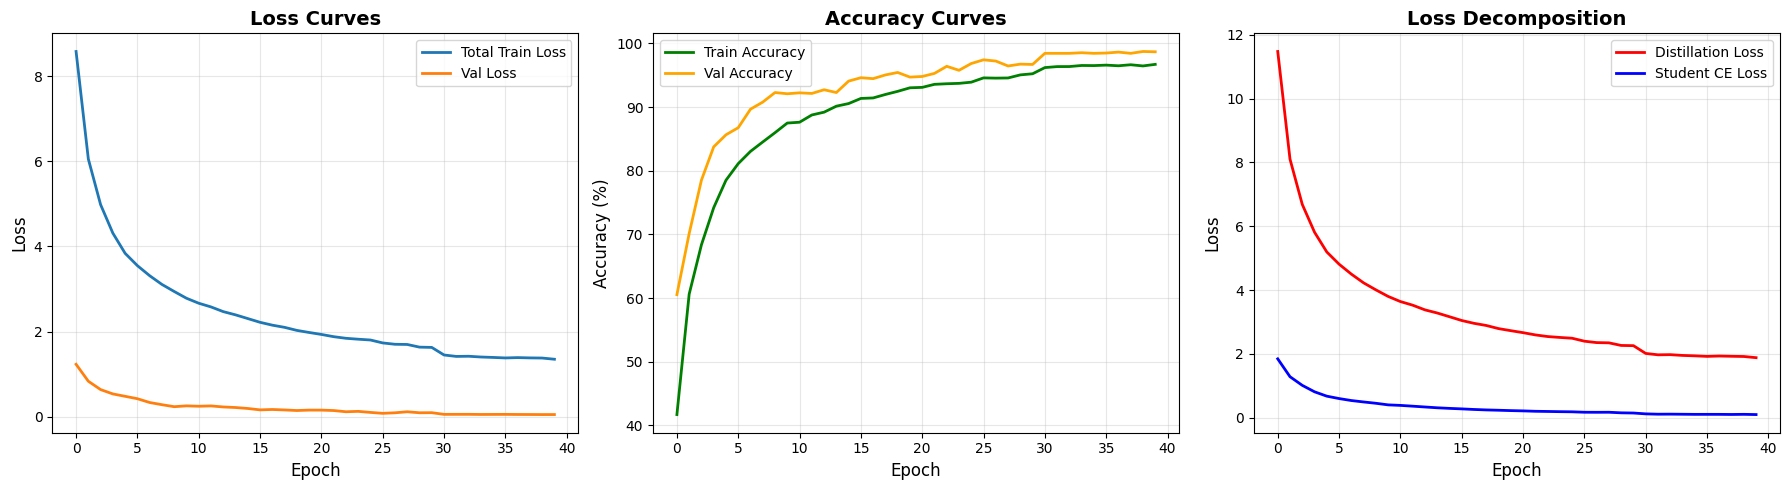

In [ ]:

class CustomCNNStudent(nn.Module):
    def __init__(self, num_classes, img_size=224):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        out = self.classifier(x)
        return out

class DistillationLoss(nn.Module):
    def __init__(self, temperature=4.0, alpha=0.7):
        super().__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.kl_div = nn.KLDivLoss(reduction='batchmean')
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, student_logits, teacher_logits, labels):
        soft_log_probs = F.log_softmax(student_logits / self.temperature, dim=1)
        soft_targets = F.softmax(teacher_logits / self.temperature, dim=1)
        distillation_loss = self.kl_div(soft_log_probs, soft_targets) * (self.temperature ** 2)
        student_loss = self.ce_loss(student_logits, labels)
        total_loss = self.alpha * distillation_loss + (1 - self.alpha) * student_loss
        return total_loss, distillation_loss.item(), student_loss.item()

def train_distillation(student, teacher, train_loader, criterion, optimizer, device):
    student.train()
    teacher.eval()
    running_loss = 0.0
    running_distill_loss = 0.0
    running_student_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc='Distillation Training'):
        inputs, labels = inputs.to(device), labels.to(device)
        with torch.no_grad():
            teacher_logits = teacher(inputs)
        optimizer.zero_grad()
        student_logits = student(inputs)
        loss, distill_loss, student_loss = criterion(student_logits, teacher_logits, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_distill_loss += distill_loss
        running_student_loss += student_loss
        _, predicted = torch.max(student_logits.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_distill_loss = running_distill_loss / len(train_loader)
    epoch_student_loss = running_student_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc, epoch_distill_loss, epoch_student_loss

def validate_student(student, val_loader, criterion, device):
    student.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc='Validating'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = student(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def plot_distillation_results(results, student_name='CustomCNN'):
    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.plot(results['train_losses'], label='Total Train Loss', linewidth=2)
    plt.plot(results['val_losses'], label='Val Loss', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.title('Loss Curves', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.subplot(1, 3, 2)
    plt.plot(results['train_accs'], label='Train Accuracy', linewidth=2, color='green')
    plt.plot(results['val_accs'], label='Val Accuracy', linewidth=2, color='orange')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.legend()
    plt.title('Accuracy Curves', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.subplot(1, 3, 3)
    plt.plot(results['distill_losses'], label='Distillation Loss', linewidth=2, color='red')
    plt.plot(results['student_losses'], label='Student CE Loss', linewidth=2, color='blue')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.title('Loss Decomposition', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    filename = f'distillation_{student_name.lower()}_results.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f'Distillation curves saved to {filename}')

def run_knowledge_distillation_customcnn(
    teacher_model_path='best_improved_resnet18plant.pth',
    num_epochs=30,
    lr=0.001,
    temperature=4.0,
    alpha=0.7,
    batch_size=32
):
    print(f"Teacher Model: {teacher_model_path}")
    raw_dataset = ImageFolder(root=data_dir)
    num_classes = len(raw_dataset.classes)
    print(f'Number of classes: {num_classes}')
    print(f'Total images: {len(raw_dataset)}')
    split_path = os.path.join(SAVE_DIR, 'data_split_indices.pth')
    if os.path.exists(split_path):
        split_indices = torch.load(split_path)
        train_indices = split_indices['train_indices']
        val_indices = split_indices['val_indices']
        test_indices = split_indices['test_indices']
        print(f'Using saved split: Train={len(train_indices)}, Val={len(val_indices)}, Test={len(test_indices)}')
    else:
        raise FileNotFoundError("Data split indices not found")
    train_subset = Subset(raw_dataset, train_indices)
    val_subset = Subset(raw_dataset, val_indices)
    test_subset = Subset(raw_dataset, test_indices)
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    train_dataset = DatasetWrapper(train_subset, transform=train_transform)
    val_dataset = DatasetWrapper(val_subset, transform=val_transform)
    test_dataset = DatasetWrapper(test_subset, transform=val_transform)
    num_workers = 2
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                            num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                           num_workers=num_workers, pin_memory=True)
    teacher_full_path = os.path.join(SAVE_DIR, teacher_model_path)
    teacher = ResNet18Plant(num_classes, pretrained=False)
    teacher.load_state_dict(torch.load(teacher_full_path, map_location=device))
    teacher = teacher.to(device)
    teacher.eval()
    student = CustomCNNStudent(num_classes, img_size=224)
    student = student.to(device)
    teacher_params = sum(p.numel() for p in teacher.parameters())
    student_params = sum(p.numel() for p in student.parameters())
    print(f"Teacher (ResNet18Plant):")
    print(f"  - Parameters: {teacher_params:,} ({teacher_params/1e6:.2f}M)")
    print(f"Student (Custom CNN):")
    print(f"  - Parameters: {student_params:,} ({student_params/1e6:.2f}M)")
    print(f"Compression ratio: {teacher_params/student_params:.2f}x")
    print(f"Model size reduction: {(1 - student_params/teacher_params)*100:.1f}%")
    distill_criterion = DistillationLoss(temperature=temperature, alpha=alpha)
    val_criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(student.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
    early_stopper = EarlyStopper(patience=8, min_delta=0.0001)
    print(f"Distillation hyperparameters:")
    print(f"  - Temperature: {temperature}")
    print(f"  - Alpha (distillation weight): {alpha}")
    print(f"  - Learning rate: {lr}")
    print(f"  - Epochs: {num_epochs}")
    print(f"  - Batch size: {batch_size}")

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    distill_losses = []
    student_losses = []
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        train_loss, train_acc, distill_loss, stu_loss = train_distillation(
            student, teacher, train_loader, distill_criterion, optimizer, device
        )
        val_loss, val_acc = validate_student(student, val_loader, val_criterion, device)
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        distill_losses.append(distill_loss)
        student_losses.append(stu_loss)
        print(f'Train Loss: {train_loss:.4f} (Distill: {distill_loss:.4f}, Student: {stu_loss:.4f})')
        print(f'Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}% | LR: {current_lr:.1e}')
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            model_path = os.path.join(SAVE_DIR, 'best_customcnn_distilled_baseline.pth')
            torch.save(student.state_dict(), model_path)
            print(f'Saved best student model with val accuracy: {best_val_acc:.2f}%')
        if early_stopper(val_loss):
            print(f'Early stopping triggered at Epoch {epoch+1}')
            break

    model_path = os.path.join(SAVE_DIR, 'best_customcnn_distilled_baseline.pth')
    student.load_state_dict(torch.load(model_path))
    test_loss, test_acc = validate_student(student, test_loader, val_criterion, device)
    print(f'Custom CNN Student Model Results:')
    print(f'  - Best Val Accuracy: {best_val_acc:.2f}%')
    print(f'  - Final Test Accuracy: {test_acc:.2f}%')

    results = {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'distill_losses': distill_losses,
        'student_losses': student_losses,
        'best_val_acc': best_val_acc,
        'test_acc': test_acc,
        'compression_ratio': teacher_params / student_params,
        'teacher_params': teacher_params,
        'student_params': student_params
    }
    plot_distillation_results(results, student_name='CustomCNN')
    return student, results


student_model, results = run_knowledge_distillation_customcnn(
    teacher_model_path='best_improved_resnet18plant.pth',
    num_epochs=40,
    lr=1e-4,
    temperature=4.0,
    alpha=0.7
)